# Задание 4

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


1. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
# преименование полей
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [4]:
# приведение значений к бинарным
df['treatment'] = df['treatment'].apply(lambda i : 0 if i == 'No Offer' else 1)

In [5]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

2. сделать разбиение набора данных не тренировочную и тестовую выборки

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.33,
                                                    random_state=42)

3. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [7]:
# One-Hot Encoding:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

4.провести uplift-моделирование 3 способами:
   1)одна модель с признаком коммуникации (S learner),
   2)модель с трансформацией таргета (трансформация классов п. 2. 1) и
   3)вариант с двумя независимыми моделями

In [8]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@30%': []
}

In [19]:
pip install scikit-uplift

Note: you may need to restart the kernel to use updated packages.


In [20]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [17]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [21]:
from catboost import CatBoostClassifier

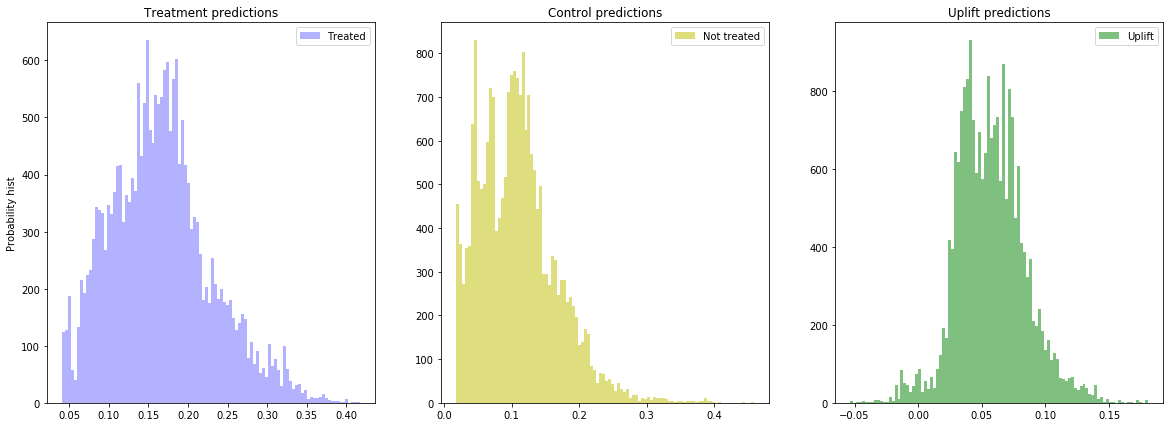

In [22]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [23]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.230532
1,treatment,15.733649
2,recency,12.950256
3,history,12.842657
4,used_bogo,12.393245
5,used_discount,7.896263
6,zip_code_Rural,7.563466
7,channel_Phone,5.956007
8,channel_Web,2.397393
9,channel_Multichannel,1.644685


модель с трансформацией таргета

In [24]:

from sklift.models import ClassTransformation

In [25]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_30)

In [26]:
from sklift.models import TwoModels

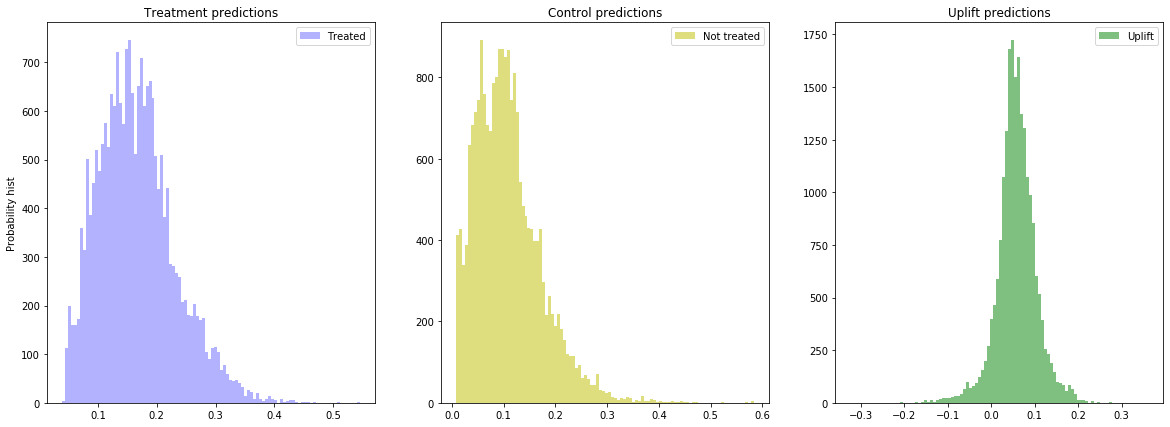

In [27]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla')

tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);


в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [28]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False).set_index('approach')

,uplift@10%,uplift@30%
approach,,
ClassTransformation,0.269593,0.183394
SoloModel,0.092437,0.085607
TwoModels,0.082563,0.082071
